# Import Required Libraries

In [1]:
import os
from datetime import datetime

# Preprocessing and Plotting Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import scipy as sp

# Set Up COLAB TPU

In [3]:
try:
    #tpu_address = os.environ['TPU_NAME']                                       # For running notebook on Kaggle notebook
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']                      # For running notebook on Colab
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)                      # Training of model takes place wrt this strategy.

    print('Running on TPU: ', tpu.cluster_spec().as_dict()['worker'])
    print('Number of accelerators: ', strategy.num_replicas_in_sync)

except ValueError:
    print('TPU failed to initialize.')

gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043


# Load Dataset

In [96]:
GCS_PATH = 'gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043'
print(GCS_PATH)

gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043


In [4]:
!gsutil ls $GCS_PATH                    # Looking at sub-dirs and files in GCS PATH

gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/README.txt
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/Segmentation_example_script.m
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/license.txt
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/Fish_Dataset/
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/NA_Fish_Dataset/


In [81]:
test_path = GCS_PATH + '/Fish_Dataset/Fish_Dataset/*/*/*'


# Define constants
IMG_SIZE = [224, 224]

CLASSES = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

In [82]:
def get_class(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]


def get_label(file_path):
    img_class = get_class(file_path)
    all_classes = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
    label = tf.convert_to_tensor(list(map((lambda x: int(x == img_class)), all_classes)))
    return label

def process_image(file_path):
    # class_ = get_class(file_path)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    # img = tf.keras.applications.vgg16.preprocess_input(img)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float64) / 255.0
    return img, label

def load_dataset(file_path):
    image_dataset = tf.data.Dataset.list_files(file_path, shuffle = True)
    image_dataset = image_dataset.filter(lambda x: tf.strings.split(get_class(x), ' ')[-1] != 'GT')
    image_dataset = image_dataset.map(process_image)
    image_dataset = image_dataset.shuffle(1024)
    image_dataset = image_dataset.batch(1024, drop_remainder = False)    
    return image_dataset

# We want to get all images in train dataset, so use batchsize much greater than size of dataset.


In [84]:
image_dataset = load_dataset(test_path)

In [85]:
images = None
labels = None
for img, label in image_dataset.take(1):
    images = img
    labels = label

# Loading And Getting Predictions from both models

In [105]:
cnn_model = tf.keras.models.load_model('Distributed_training_model.h5')
vgg16_model = tf.keras.models.load_model('Transfer_model-VGG16.h5')

In [98]:
vgg16_pred = vgg16_model(images)
cnn_pred = cnn_model(images)

In [99]:
actual_class = np.argmax(labels.numpy(), axis = -1)
cnn_pred_class = np.argmax(cnn_pred.numpy(), axis = -1)
vgg16_pred_class = np.argmax(vgg16_pred.numpy(), axis = -1)

In [100]:
print(actual_class.shape,
      cnn_pred_class.shape,
      vgg16_pred_class.shape)

(1024,) (1024,) (1024,)


# Classification Report And Confusion Matrix of Predictions

In [101]:
print('\t\t CNN MODEL CLASSIFICATION REPORT')
print(classification_report(actual_class, cnn_pred_class))

		 CNN MODEL CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       121
           3       0.99      1.00      1.00       104
           4       1.00      1.00      1.00       112
           5       1.00      1.00      1.00       106
           6       1.00      0.99      1.00       133
           7       1.00      1.00      1.00       117
           8       1.00      1.00      1.00       101

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [102]:
print('\t\t VGG16 TRANSFER MODEL CLASSIFICATION REPORT')
print(classification_report(actual_class, vgg16_pred_class))

		 VGG16 TRANSFER MODEL CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       121
           3       1.00      1.00      1.00       104
           4       1.00      1.00      1.00       112
           5       1.00      1.00      1.00       106
           6       1.00      1.00      1.00       133
           7       1.00      1.00      1.00       117
           8       1.00      1.00      1.00       101

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [104]:
print('\t\t CNN MODEL CONFUSION MATRIX')
print(confusion_matrix(actual_class, cnn_pred_class))

		 CNN MODEL CONFUSION MATRIX
[[110   0   0   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0   0   0]
 [  0   0 121   0   0   0   0   0   0]
 [  0   0   0 104   0   0   0   0   0]
 [  0   0   0   0 112   0   0   0   0]
 [  0   0   0   0   0 106   0   0   0]
 [  0   0   0   1   0   0 132   0   0]
 [  0   0   0   0   0   0   0 117   0]
 [  0   0   0   0   0   0   0   0 101]]


In [103]:
print('\t\t VGG16 TRANSFER MODEL CONFUSION MATRIX')
print(confusion_matrix(actual_class, vgg16_pred_class))

		 VGG16 TRANSFER MODEL CONFUSION MATRIX
[[110   0   0   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0   0   0]
 [  0   0 121   0   0   0   0   0   0]
 [  0   0   0 104   0   0   0   0   0]
 [  0   0   0   0 112   0   0   0   0]
 [  0   0   0   0   0 106   0   0   0]
 [  0   0   0   0   0   0 133   0   0]
 [  0   0   0   0   0   0   0 117   0]
 [  0   0   0   0   0   0   0   0 101]]


### Observations-
    -> We observe that both the models are doing great.
    -> CNN MODEL gave one wrong classification.

# Class Activation Maps
    -> See Class Activation Maps of a few random images through both the models

In [107]:
vgg16_feature_extractor = tf.keras.Model(
    inputs = vgg16_model.input,
    outputs = (vgg16_model.layers[-3].output, vgg16_model.layers[-1].output)
)


cnn_feature_extractor = tf.keras.Model(
    inputs = cnn_model.input,
    outputs = (cnn_model.layers[-3].output, cnn_model.layers[-1].output)
)



In [108]:
vgg_features, vgg_results = vgg16_feature_extractor(images[:10, :, :, :])
cnn_features, cnn_results = cnn_feature_extractor(images[:10, :, :, :])

In [109]:
gap_weights_vgg = vgg16_model.layers[-1].get_weights()[0]
gap_weights_cnn = cnn_model.layers[-1].get_weights()[0]

In [140]:
def show_vgg_cam(image_index, axis):
    features_for_img = vgg_features[image_index, :, :, :]
    prediction = np.argmax(vgg_results[image_index])

    class_activation_weights = gap_weights_vgg[:, prediction]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order = 2)
    cam_output = np.dot(class_activation_features, class_activation_weights)

    # print("Predicted Class = " + str(CLASSES[prediction]) + ', Probability = ' + str(vgg_results[image_index][prediction]))
    axis.imshow(images[image_index])

    if vgg_results[image_index][prediction] > 0.95:
        cmap_str = "PiYG_r"
    else:
        cmap_str = "Reds"
    
    axis.imshow(cam_output, cmap = cmap_str, alpha = 0.7)
    axis.axis('off')
    axis.set_title('VGG16 CAM for ' + str(CLASSES[prediction]))



def show_cnn_cam(image_index, axis):
    features_for_img = cnn_features[image_index, :, :, :]
    prediction = np.argmax(cnn_results[image_index])

    class_activation_weights = gap_weights_cnn[:, prediction]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/4, 224/4, 1), order = 2)
    cam_output = np.dot(class_activation_features, class_activation_weights)

    # print("Predicted Class = " + str(CLASSES[prediction]) + ', Probability = ' + str(cnn_results[image_index][prediction]))
    axis.imshow(images[image_index])

    if cnn_results[image_index][prediction] > 0.95:
        cmap_str = "PiYG_r"
    else:
        cmap_str = "Reds"
    
    axis.imshow(cam_output, cmap = cmap_str, alpha = 0.7)
    axis.axis('off')
    axis.set_title('CNN CAM for ' + str(CLASSES[prediction]))

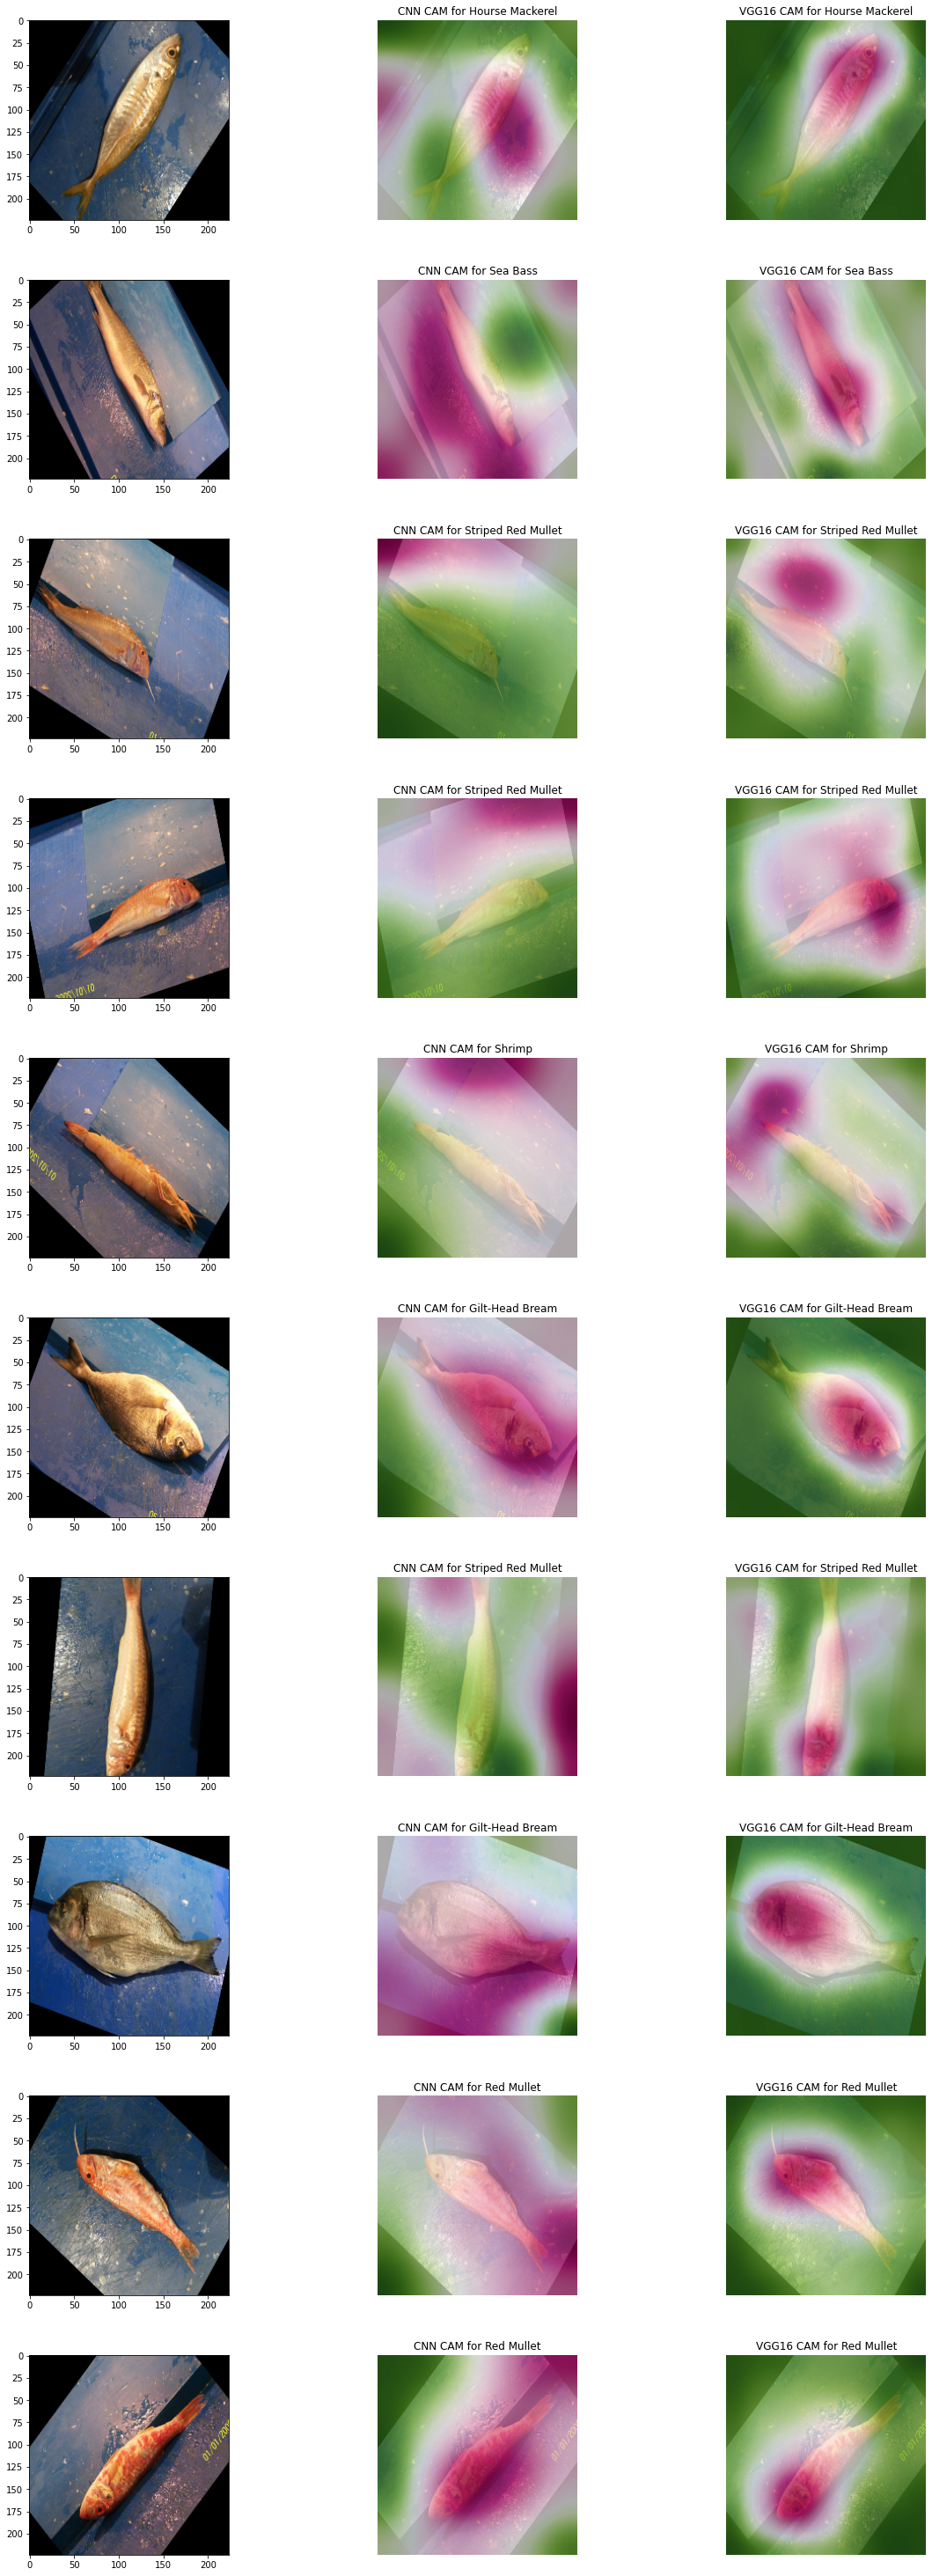

In [141]:
fig, axes = plt.subplots(10, 3, figsize = (20, 50))

for i in range(10):
    axes[i, 0].imshow(images[i])
    show_cnn_cam(i, axes[i, 1])
    show_vgg_cam(i, axes[i, 2])


plt.subplots_adjust(
    left=0.1,
    bottom = 0.1,
    right=0.9,
    top = 0.9,
    wspace=0.1,
    hspace = 0.3
)

## Observations From CAMs
    -> Although performance of both the models was great, the VGG16 model was far better in exactly locating the center of attention.
    -> Where VGG16 model's classification was severely based on head and eyes of the fish, the center of attention in CNN model was often not even close to the fish.